In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id', parse_dates=['time1'])

train_df.sort_values('time1', inplace=True)

In [4]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')


y_train = train_df.target.values
train_df.drop('target', axis = 1, inplace=True)


idx_split = y_train.shape[0]

In [5]:
train_df['sites_chain'] = train_df[sites].apply(lambda x: " ".join([str(a) for a in x]), axis = 1)
test_df['sites_chain'] = test_df[sites].apply(lambda x: " ".join([str(a) for a in x]), axis = 1)

In [6]:
CV = CountVectorizer(ngram_range=(1,3), max_features=50000)
train_count = CV.fit_transform(train_df.sites_chain.values)
test_count = CV.transform(test_df.sites_chain.values)

In [7]:
# Создаю класс для временной кросс-валидации
time_splite = TimeSeriesSplit(n_splits = 12)

logit = LogisticRegression(random_state=17, solver='liblinear', C=1)

In [8]:
# Проверяем качество и замеряем время
cross = cross_val_score(logit, train_count, y_train, cv = time_splite, n_jobs=1, scoring='roc_auc')

cross, cross.mean()

(array([0.60872269, 0.59023693, 0.74276713, 0.87304067, 0.96603495,
        0.8395655 , 0.89302288, 0.95672173, 0.90259054, 0.86324522,
        0.9298164 , 0.90535097]), 0.8392596331017655)

In [9]:
# Все тоже самое, но с tf_idf 
TF = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
train_tfidf = TF.fit_transform(train_df.sites_chain.values)
test_tfidf = TF.transform(test_df.sites_chain.values)

cross = cross_val_score(logit, train_tfidf, y_train, cv = time_splite, n_jobs=1, scoring='roc_auc')
cross, cross.mean()

(array([0.66984886, 0.58689845, 0.74977828, 0.87615507, 0.93698034,
        0.84467218, 0.90207973, 0.94101084, 0.86448651, 0.88840213,
        0.92694919, 0.92248443]), 0.842478833360346)

In [10]:
# Проверяю сабмит
logit.fit(train_tfidf, y_train)
pred = logit.predict_proba(test_tfidf)[:, 1]

pd.DataFrame(pred, index=np.arange(pred.shape[0]) + 1, columns=['target']).to_csv('sub_1.csv', index_label='session_id')

**Скор CountVectorizer - 0.9128**  
**Скор TF-IDF - 0.9188**

In [11]:
# Пробую выкинуть слова с маленькой дисперсией и тренироваться на оставшихся

#TF = TfidfVectorizer(ngram_range=(1, 3), max_features=100000)
#train_tfidf = TF.fit_transform(train_df.sites_chain.values)
#test_tfidf = TF.transform(test_df.sites_chain.values)

# Var = VarianceThreshold(threshold=0.000003)
# Var.fit(train_tfidf)

# print(Var.get_support().sum())

# cross = cross_val_score(logit, Var.transform(train_tfidf), y_train, cv = time_splite, n_jobs=1, scoring='roc_auc')
# cross, cross.mean()

**Добовляю временные фичи**

In [12]:
times = ['time%s' % i for i in range(1, 11)]

train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

full_df = pd.concat([train_df, test_df]).reset_index(drop=True)

idx_split = y_train.shape[0]

time_features = pd.DataFrame(index=full_df.index)

In [13]:
time_features = pd.DataFrame(index=full_df.index)
time_features['hour'] = full_df['time1'].dt.hour

hour_onehot = pd.get_dummies(time_features.hour)
hour_onehot.columns = ['hour' + str(i) for i in hour_onehot.columns]
time_features = pd.concat([time_features, hour_onehot], axis = 1)
hour_onehot = hour_onehot.columns

cross = cross_val_score(logit, 
                       csr_matrix(hstack([train_tfidf, time_features[hour_onehot].values[:idx_split, :]])),
                       y_train, cv = time_splite,
                       n_jobs=1, scoring='roc_auc')

cross, cross.mean()

(array([0.80781538, 0.69898821, 0.91937891, 0.96442855, 0.94909413,
        0.93487243, 0.97807737, 0.8480238 , 0.89527034, 0.9683573 ,
        0.96295344, 0.96982248]), 0.9080901946280613)

In [14]:
def add_time_features(input_df):
    df = pd.DataFrame(index=input_df.index)
    df['hour'] = input_df['time1'].apply(lambda ts: ts.hour)
    df['morning'] = ((df.hour >= 7) & (df.hour <= 11)).astype('int')
    df['day'] = ((df.hour >= 12) & (df.hour <= 18)).astype('int')
    df['evening'] = ((df.hour >= 19) & (df.hour <= 23)).astype('int')
    df['night'] = ((df.hour >= 0) & (df.hour <= 6)).astype('int')
    return df.drop('hour', axis = 1)

tmp = add_time_features(full_df.fillna(0))

cross = cross_val_score(logit, 
                        hstack([tmp.values[:idx_split, :], train_tfidf]),
                       y_train, cv = time_splite,
                       n_jobs=1, scoring='roc_auc')

cross, cross.mean()

(array([0.63387762, 0.75778535, 0.87197447, 0.91826987, 0.96818928,
        0.9225646 , 0.95778047, 0.94569625, 0.92664923, 0.95330479,
        0.95025629, 0.95021115]), 0.8963799468130796)

In [15]:
# One_hot работает чуть лучше для часов дня. Их оставлю, а биннинг сохраню, что бы потом проверить перебором
features_to_check = tmp

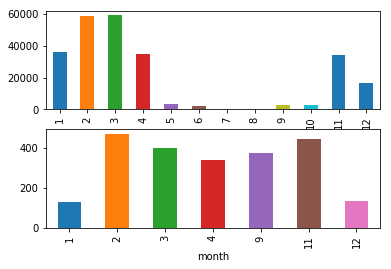

In [16]:
time_features['month'] = full_df.time1.dt.month
time_features['target'] = np.concatenate([y_train, np.array([999] * test_df.shape[0])])

plt.subplot(2, 1, 1)
time_features[time_features.target == 0].groupby('month').size().plot(kind = 'bar')
plt.subplot(2, 1, 2)
time_features[time_features.target == 1].groupby('month').size().plot(kind = 'bar')

In [17]:
def check_cross(tmp_feat, tfidf_df, time_feat):
    mix = csr_matrix(hstack([train_tfidf,
                            tmp_feat[:idx_split, :],
                            time_feat[:idx_split, :]]))
    cross = cross_val_score(logit, mix, y_train, cv = time_splite, n_jobs=-1, scoring='roc_auc')
    return (cross, cross.mean())


    
tmp = pd.DataFrame(index=full_df.index)
tmp['month'] = full_df.time1.dt.month
tmp = pd.concat([tmp, pd.get_dummies(tmp.month, prefix = 'month')], axis = 1)

# Выкину month, что бы пока не скейлить
print('Для OneHot ', check_cross(tmp.drop('month', axis = 1).values, train_tfidf, time_features.drop(['month', 'hour', 'target'], axis = 1).values))

def add_month_features(input_df):
    df = pd.DataFrame(index = input_df.index)
    df['month'] = input_df.time1.dt.month
    df['winter'] = ((df.month == 12) & (df.month <= 2)).astype('int')
    df['spring'] = ((df.month >= 3) & (df.month <= 5)).astype('int')
    df['summer'] = ((df.month == 6) & (df.month <= 8)).astype('int')
    df['fall'] = ((df.month >= 9) & (df.month <= 11)).astype('int')
    return df.drop('month', axis = 1)
    
print('Для бининга ', check_cross(add_month_features(full_df).values, train_tfidf, time_features.drop(['month', 'hour', 'target'], axis = 1).values))

Для OneHot  (array([0.69753488, 0.72683527, 0.92691171, 0.96431124, 0.94736835,
       0.94021446, 0.97515356, 0.88959606, 0.90696112, 0.96842024,
       0.96395632, 0.9717109 ]), 0.9065811753754724)
Для бининга  (array([0.81218968, 0.69395426, 0.92293957, 0.9640927 , 0.94917111,
       0.93410123, 0.97802178, 0.85758525, 0.90277521, 0.96858113,
       0.96394432, 0.97069897]), 0.9098379344828258)


In [18]:
# Становится не удобно, что есть фичи которые нужно стандартизировать и таргет мешает. Фичи для стандартизации тоже отдельно выделю
features_to_scale = time_features[['hour', 'month']]
time_features = time_features.drop(['hour', 'month', 'target'], axis = 1)
time_features = pd.concat([time_features, tmp.drop('month', axis = 1)], axis = 1)
features_to_check = pd.concat([features_to_check, add_month_features(full_df)], axis = 1)

In [19]:
def add_mix_features(df):
    '''
    Сделаю: количество посещенных сайтов, количество уникальных, год, количество секунд от первого до последнего, среднее время на сайте
    '''
    tmp_df = pd.DataFrame(df.time1.dt.year)
    tmp_df['min'] = df[times].min(axis = 1)
    tmp_df['max'] = df[times].max(axis = 1)
    tmp_df['seconds'] = (tmp_df['max'] - tmp_df['min']).dt.seconds
    tmp_df['count'] = df[sites].apply(lambda x: np.sum(x != 0), axis = 1)
    tmp_df['n_unique'] = df[sites].apply(lambda x: x[x != 0].nunique(), axis = 1)
    tmp_df['mean_seconds'] = tmp_df.seconds / tmp_df['count']
    tmp_df = tmp_df.drop(['min', 'max'], axis = 1)
    return tmp_df

scl = StandardScaler()

tmp = add_mix_features(full_df)

print('С новыми фичами ', check_cross(scl.fit_transform(tmp.values), train_tfidf, time_features.values))

С новыми фичами  (array([0.72286815, 0.74807704, 0.76462428, 0.96403783, 0.90421115,
       0.94323927, 0.97536912, 0.87533454, 0.90279573, 0.96950057,
       0.96195656, 0.97253296]), 0.8920456007487423)


In [20]:
# Эти фичи не дают результата сохраню их пока отдельно
features_to_check = pd.concat([features_to_check, tmp], axis = 1)

In [21]:
# Добавлю еще порядковый месяц
tmp = pd.DataFrame(index=full_df.index)
tmp['year']  = full_df.time1.dt.year
tmp['number_month'] = features_to_scale.month + 12 * (tmp.year - 2013)
tmp['yyyymm'] = tmp.year * 100 + features_to_scale.month

tmp_features = scl.fit_transform(tmp.values)

check_cross(tmp_features, train_tfidf, time_features.values)

(array([0.73043763, 0.72874022, 0.761608  , 0.9643032 , 0.8732152 ,
        0.9405637 , 0.97518805, 0.88954229, 0.9072689 , 0.96845526,
        0.96243828, 0.97173118]), 0.8894576605535555)

In [22]:
# Тоже результата не дали фичи. Буду перебирать потом
features_to_scale = pd.concat([features_to_scale, tmp], axis = 1)

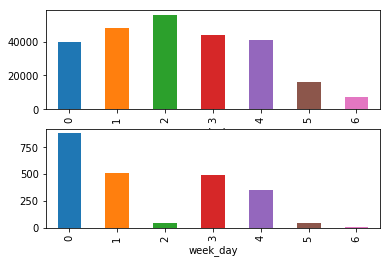

In [23]:
# Посмотрю какое распределение по дням недели
tmp = pd.DataFrame(index=full_df.index)
tmp['week_day'] = full_df.time1.dt.weekday
tmp['target'] = np.concatenate([y_train, np.array([999] * test_df.shape[0])])

plt.subplot(2, 1, 1)
tmp[tmp.target == 0].groupby('week_day').size().plot(kind = 'bar')
plt.subplot(2, 1, 2)
tmp[tmp.target == 1].groupby('week_day').size().plot(kind = 'bar')

In [24]:
# Кажется Алиса совсем не заходит по средам и выходным
tmp = tmp.drop('target', axis = 1)
tmp = pd.concat([tmp, pd.get_dummies(tmp.week_day, prefix = 'week_day')], axis = 1)
tmp['weekend'] = tmp.week_day.apply(lambda x: 1 if x >= 5 else 0)

check_cross(tmp.values, train_tfidf, time_features.values)

(array([0.70238622, 0.82310808, 0.94634725, 0.87521564, 0.95685434,
        0.89441358, 0.98163982, 0.89146582, 0.90041551, 0.98103122,
        0.83472622, 0.98643392]), 0.8978364697068665)

In [25]:
# Пока результата на кросс-валидации лучше чем 0.909 не получается. Есть еще идеи по фичам, но хочу перебрать имеющиеся и найти лучшую комбинацию.
from mlxtend.feature_selection import SequentialFeatureSelector

In [59]:
sfs = SequentialFeatureSelector(logit,
                               k_features=13,
                               forward=True,
                               verbose=2,
                               scoring='roc_auc',
                               cv=time_splite)
sfs_res = sfs.fit(scl.fit_transform(features_to_check.values)[:idx_split, :], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   17.4s finished

[2019-03-06 19:06:55] Features: 1/13 -- score: 0.7554789276035248[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   23.4s finished

[2019-03-06 19:07:18] Features: 2/13 -- score: 0.8051532636798459[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   23.8s finished

[2019-03-06 19:07:42] Features: 3/13 -- score: 0.8117686817854218[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [60]:
sfs_res.subsets_[7]

{'feature_idx': (1, 2, 5, 7, 9, 10, 12),
 'cv_scores': array([0.79607409, 0.81951204, 0.80164337, 0.75537131, 0.79023301,
        0.83150109, 0.86544321, 0.8644056 , 0.81823895, 0.88187768,
        0.78350691, 0.79609744]),
 'avg_score': 0.8169920582799923,
 'feature_names': ('1', '2', '5', '7', '9', '10', '12')}

In [68]:
time_features.values[:idx_split, :]

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [80]:
sfs = SequentialFeatureSelector(logit,
                               k_features=29,
                               forward=True,
                               verbose=2,
                               scoring='roc_auc',
                               cv=TimeSeriesSplit(n_splits = 5))
sfs_res_2 = sfs.fit(time_features.values[:idx_split, :], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   15.5s finished

[2019-03-06 19:30:08] Features: 1/29 -- score: 0.6275654107923658[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   18.1s finished

[2019-03-06 19:30:26] Features: 2/29 -- score: 0.7330234023728137[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   20.0s finished

[2019-03-06 19:30:46] Features: 3/29 -- score: 0.8074605651632453[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [81]:
sfs.subsets_[13]

{'feature_idx': (0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 17, 18, 19),
 'cv_scores': array([0.82691608, 0.86692016, 0.90179956, 0.92416531, 0.91744674]),
 'avg_score': 0.8874495702255094,
 'feature_names': ('0',
  '1',
  '3',
  '4',
  '5',
  '6',
  '7',
  '9',
  '10',
  '11',
  '17',
  '18',
  '19')}

In [58]:
sfs = SequentialFeatureSelector(logit,
                               k_features=5,
                               forward=True,
                               verbose=2,
                               scoring='roc_auc',
                               cv=time_splite)
sfs_res_3 = sfs.fit(scl.fit_transform(features_to_scale.values)[:idx_split, :], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.3s finished

[2019-03-06 19:05:53] Features: 1/5 -- score: 0.8113706856380517[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.8s finished

[2019-03-06 19:05:59] Features: 2/5 -- score: 0.8166575054213413[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s finished

[2019-03-06 19:06:04] Features: 3/5 -- score: 0.8006891973787859[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [73]:
sfs_res_3.subsets_[2]

{'feature_idx': (0, 3),
 'cv_scores': array([0.88095308, 0.49317893, 0.8286175 , 0.85902212, 0.93770145,
        0.75292028, 0.9059435 , 0.79775286, 0.71009028, 0.86466243,
        0.90070202, 0.86834562]),
 'avg_score': 0.8166575054213413,
 'feature_names': ('0', '3')}

In [98]:
tmp = pd.concat([features_to_check.iloc[:, [1, 2, 5, 7, 9, 10, 12]],
                 time_features.iloc[:, [0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 17, 18, 19]],
                 features_to_scale.iloc[:, [0, 3]]], axis = 1)
logit_2 = LogisticRegression(C=0.2154434, random_state=17, n_jobs=-1)
cross = cross_val_score(logit_2, csr_matrix(hstack([train_tfidf, scl.fit_transform(tmp.values[:idx_split, :])])), y_train, cv = time_splite, n_jobs=-1, scoring='roc_auc')
cross, cross.mean()

(array([0.70876947, 0.72572094, 0.90260115, 0.95023356, 0.92288544,
        0.92504239, 0.97876685, 0.79801194, 0.86047502, 0.96982407,
        0.95084859, 0.96777055]), 0.8884124974772253)

In [99]:
logit = LogisticRegression(random_state=17, solver='liblinear', C=1.6681005)
logit.fit(csr_matrix(hstack([tmp.values[:idx_split, :], train_tfidf])), y_train)
pred = logit.predict_proba(csr_matrix(hstack([tmp.values[idx_split:, :], test_tfidf])))

pred = pred[:, 1]
pd.DataFrame(pred, index=np.arange(1, pred.shape[0] + 1), columns=['target']).\
        to_csv('subs/sub_3.csv', index_label="session_id")

In [89]:
pred = pred[:, 1]
pd.DataFrame(pred, index=np.arange(1, pred.shape[0] + 1), columns=['target']).\
        to_csv('subs/sub_2.csv', index_label="session_id")